Imports:

In [ ]:
import os
import time
import json

import numpy as np
import pandas as pd
import torch

from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments



Create dataFrame for the question assessment

In [ ]:
# Specify the path to the text file
file_path = '2024-question-assessment.txt'

array = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.split("\t")
        if (line[5] == "4" or line[5] == "3"):
            array.append(line)
            
        
dataFrame = pd.DataFrame(array)
dataFrame.columns = ["AID", "Article", "RID", "Model", "Order", "Assessment", "Useless", "Question"]
dataFrame.drop(columns=["AID", "Model", "RID", "Useless", "Order"], inplace=True)

dataFrame.head()

,Article,Assessment,Question
0,clueweb22-en0030-87-05450,3,What are the qualifications of the creators of...
1,clueweb22-en0030-87-05450,3,What is Anne Lise Marstrand-Jørgensen's expert...
2,clueweb22-en0030-87-05450,3,Does the Danish public service broadcaster DR ...
3,clueweb22-en0030-87-05450,3,What evidence supports the claim that the show...
4,clueweb22-en0030-87-05450,3,What is the broader context of Danish children...


Creates a DataFrame from the clueweb22 dataset.

In [ ]:
# Specify the path to the text file
file_path = '../trec-2024-lateral-reading-task2-baseline-documents.json'

f = open(file_path)
data = json.load(f)
articles_df = pd.DataFrame.from_dict(data)
articles_df.head()



,URL,URL-hash,Language,ClueWeb22-ID,Clean-Text
0,https://www.dailymail.co.uk/news/article-10130...,1F1D55AC16DCD50B1560DE585165466D,en,clueweb22-en0032-91-05114,"Japan's Princess Mako marries commoner, loses ..."
1,https://www.nytimes.com/2021/08/26/opinion/afg...,4CC82FB7D4CB6DE296C887E0F7F82C57,en,clueweb22-en0027-70-17775,Opinion | Let’s Not Pretend That the Way We Wi...
2,https://www.politicshome.com/thehouse/article/...,357F722430ABDA02F9757BD8E4DF0CAA,en,clueweb22-en0032-18-01494,No longer can China’s atrocities against the U...
3,https://medicaladvise.org/clinical-trials-rese...,D0823CAF7F01DCC0D8112D527D936B86,en,clueweb22-en0012-53-13803,How does molnupiravir work? - Medical Advise\n...
4,https://www.euronews.com/2021/12/10/mexico-tru...,C623D58493D0F372CC5E56F59BD20611,en,clueweb22-en0002-69-11564,Mexico truck crash: Dozens killed after lorry ...


Prompt for labeling our data into categories, outputs as an csv file named output.csv

In [ ]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# Initialize client properly
client = OpenAI(api_key=api_key)
qArray = [row[7] for row in array]  # Adjust if needed

def format_prompt(qs):
    categories = [
        "Author Bias",
        "Factual Query",
        "Author Reputation",
        "Publication Reputation"
    ]
    prompt = f"Classify each of the following questions into one of these categories per line: {', '.join(categories)}.\n\n"
    prompt_tail = (
        '\nReturn the result as plain CSV with no extra text. Each row should have two columns: '
        '"Question" and "Category". Format like this:\n\n'
        '"Question","Category"\n'
        '"Example question here?","Author Bias"\n')
    for i, q in enumerate(qs, 1):
        prompt += f"{i}. {q.strip()}\n"
    prompt += prompt_tail
    return prompt

# Batch the questions to avoid exceeding token/context limits
batch_size = 20  # Adjust as needed for your model/context
prompts = [format_prompt(qArray[i:i+batch_size]) for i in range(0, len(qArray), batch_size)]
outputs = []

for prompt_text in tqdm(prompts, desc="Processing batches"):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt_text}],
        temperature=0
    )
    outputs.append(response.choices[0].message.content)
    time.sleep(0.2) 
# Save all outputs to a single CSV file
with open("output.csv", "w", encoding="utf-8") as f:
    header_written = False
    for output in outputs:
        lines = output.strip().splitlines()
        if not header_written:
            f.write(lines[0] + "\n")  # Write header
            header_written = True
        for line in lines[1:]:
            f.write(line + "\n")

Processing batches: 100%|██████████| 236/236 [23:14<00:00,  5.91s/it]


Load all data into train_test_split and add it to a BERT readable database

In [31]:
df1 = pd.read_csv("output.csv", header=None, names=["Question", "Category"])

col1 = df1.iloc[:, 0].to_numpy()
col2 = df1.iloc[:, 1].to_numpy()


Q_train, Q_test, c_train, c_test = train_test_split(col1, col2, test_size=0.3, random_state=42)


# Define label names for readability (optional)
label_names = ["Author Bias",
        "Factual Query",
        "Author Reputation",
        "Publication Reputation"]

# Load tokenizer and model with built-in classification head
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_names))


le = LabelEncoder()
# Define custom Dataset class
class TextDataset(Dataset):
    def __init__(self, Q_train, c_train):
        self.encodings = tokenizer(Q_train, truncation=True, padding=True, return_tensors="pt")
        c_train_encoded = le.fit_transform(c_train) 
        self.labels = torch.tensor(c_train_encoded)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Prepare dataset
dataset = TextDataset(list(Q_train), list(c_train))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defines hyperparameters for the model and trains it.

In [ ]:


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"
)

# Set up Trainer API to handle training loop
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_model")


Load trained model from disk

In [ ]:
model = BertForSequenceClassification.from_pretrained("./fine_tuned_model")

Use the model to make predictions on the test data

In [ ]:


Q_test_list = Q_test.astype(str).tolist()
batch_size = 32  # Tune this based on your RAM

predictions = []

# Wrap the range with tqdm for a progress bar
for i in tqdm(range(0, len(Q_test_list), batch_size), desc="Running inference"):
    batch = Q_test_list[i:i+batch_size]
    test_encodings = tokenizer(batch, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**test_encodings)
        batch_preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(batch_preds)

# Print results
for text, label_idx in zip(Q_test_list, predictions):
    print(f"{text} -> {label_names[label_idx]}")


Running inference: 100%|██████████| 45/45 [02:06<00:00,  2.81s/it]

What is Kevin O'Leary's track record as an investor? -> Author Reputation
Is Mark Farmaner's Burma Campaign UK a reliable source on Myanmar's human rights? -> Author Reputation
What are the qualifications of Randall Munroe in discussing human tolerance to high temperatures? -> Author Reputation
What methodologies were used in the malaria vaccine trials to ensure accuracy and reliability? -> Author Reputation
What are the credentials and potential biases of Rebecca Parma, the author of the article? -> Author Reputation
How accurate are leaks like the Pandora and Panama Papers in revealing financial misconduct? -> Author Reputation
Who is the author, Skyler Caruso? -> Author Reputation
What are Donald Maier's credentials as Dean of Cal Maritime's School of Maritime Transportation? -> Author Reputation
How reliable is the data from the World Health Organization regarding malaria cases and deaths? -> Author Reputation
How accurate are the forecasts by ERCOT's manager of resource adequacy, 

In [37]:
predicted_labels = [label.item() for label in predictions]
print(batch_preds)

tensor([2, 2, 2, 2, 2, 2, 2])


Prints out a classifcation report for the test data output

Accuracy: 0.8989399293286219

Classification Report:
                        precision    recall  f1-score   support

           Author Bias       0.80      0.73      0.76        96
     Author Reputation       0.93      0.91      0.92       345
         Factual Query       0.91      0.91      0.91       604
Publication Reputation       0.87      0.91      0.89       370

              accuracy                           0.90      1415
             macro avg       0.88      0.87      0.87      1415
          weighted avg       0.90      0.90      0.90      1415



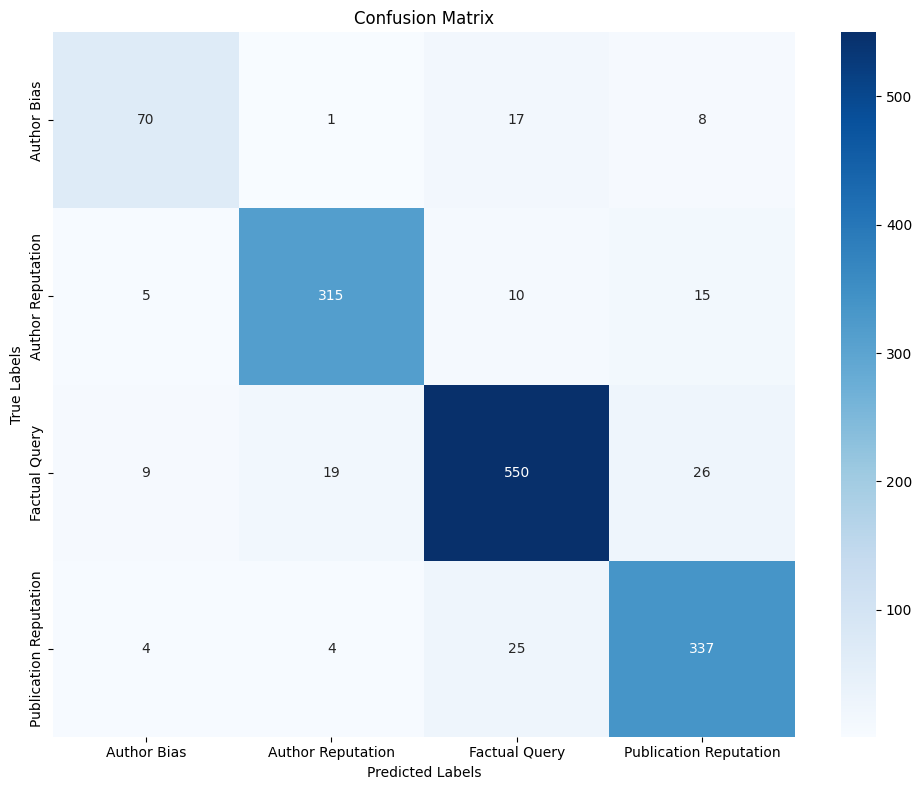

Text: What is Kevin O'Leary's track record as an investor?
True: Factual Query
Pred: Factual Query
--------------------------------------------------
Text: Is Mark Farmaner's Burma Campaign UK a reliable source on Myanmar's human rights?
True: Publication Reputation
Pred: Publication Reputation
--------------------------------------------------
Text: What are the qualifications of Randall Munroe in discussing human tolerance to high temperatures?
True: Factual Query
Pred: Factual Query
--------------------------------------------------
Text: What methodologies were used in the malaria vaccine trials to ensure accuracy and reliability?
True: Author Reputation
Pred: Author Reputation
--------------------------------------------------
Text: What are the credentials and potential biases of Rebecca Parma, the author of the article?
True: Author Bias
Pred: Author Bias
--------------------------------------------------
Text: How accurate are leaks like the Pandora and Panama Papers in reveali

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse the label encoder used during training

le.fit_transform(c_train)  # Fit on the training labels

# Convert c_test (strings) to integer labels


# Convert predicted tensor to list of integers
predicted_labels = [label.item() for label in predictions]

# Accuracy
print("Accuracy:", accuracy_score(actual_labels, predicted_labels))

# Classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


for i in range(50):
    print(f"Text: {Q_test_list[i]}")
    print(f"True: {label_names[actual_labels[i]]}")
    print(f"Pred: {label_names[predicted_labels[i]]}")
    print("-" * 50)

